## Dependencies

In [1]:
%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

C:\Users\Abhijit\Documents\GitHub\cpsc490\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [2]:
dataset = Planetoid(root='../data/Cora', name='Cora')

data = dataset[0]

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:data.num_nodes - 1000] = 1

data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask[data.num_nodes - 1000:data.num_nodes - 500] = 1

data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[data.num_nodes - 500:] = 1

## Model

In [3]:
class Net(torch.nn.Module):
    def __init__(self, num_features, dim=16, num_classes=1):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, dim)
        self.conv2 = GCNConv(dim, num_classes)

    def forward(self, x, edge_index, data=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## Training

In [4]:
epochs = 200
dim = 16

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=dataset.num_features, dim=dim, num_classes=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

In [6]:
def test(model, data):
    model.eval()
    logits, accs = model(data.x, data.edge_index, data), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [7]:
train_acc, val_acc, test_acc = 0, 0, 0
data = data.to(device)

for epoch in range(epochs):
    model.train()
    loss = 0
    optimizer.zero_grad()
    log_logits = model(data.x, data.edge_index, data)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # validate
    train_acc, val_acc, test_acc = test(model, data)
    train_loss = loss
    
    print('Train_loss:{:.6f} Train_acc: {:.4f}, Val_acc: {:.4f}, Test_acc: {:.4f}'.format(loss, train_acc, val_acc, test_acc))

Train_loss:1.960827 Train_acc: 0.4520, Val_acc: 0.4320, Test_acc: 0.5040
Train_loss:1.883437 Train_acc: 0.4063, Val_acc: 0.3500, Test_acc: 0.4600
Train_loss:1.799201 Train_acc: 0.4333, Val_acc: 0.3640, Test_acc: 0.4840
Train_loss:1.694223 Train_acc: 0.5310, Val_acc: 0.4460, Test_acc: 0.5720
Train_loss:1.596567 Train_acc: 0.6101, Val_acc: 0.5500, Test_acc: 0.6620
Train_loss:1.503236 Train_acc: 0.6739, Val_acc: 0.5920, Test_acc: 0.7060
Train_loss:1.406579 Train_acc: 0.7119, Val_acc: 0.6300, Test_acc: 0.7360
Train_loss:1.335606 Train_acc: 0.7295, Val_acc: 0.6520, Test_acc: 0.7540
Train_loss:1.232419 Train_acc: 0.7494, Val_acc: 0.6680, Test_acc: 0.7720
Train_loss:1.171421 Train_acc: 0.7594, Val_acc: 0.6820, Test_acc: 0.7820
Train_loss:1.113300 Train_acc: 0.7722, Val_acc: 0.7000, Test_acc: 0.7940
Train_loss:1.046683 Train_acc: 0.7869, Val_acc: 0.7060, Test_acc: 0.7980
Train_loss:0.987728 Train_acc: 0.7992, Val_acc: 0.7160, Test_acc: 0.8020
Train_loss:0.950119 Train_acc: 0.8162, Val_acc: 0.7

Train_loss:0.325385 Train_acc: 0.9479, Val_acc: 0.8680, Test_acc: 0.8980
Train_loss:0.339499 Train_acc: 0.9491, Val_acc: 0.8700, Test_acc: 0.8980
Train_loss:0.344834 Train_acc: 0.9479, Val_acc: 0.8700, Test_acc: 0.8980
Train_loss:0.338919 Train_acc: 0.9491, Val_acc: 0.8700, Test_acc: 0.8980
Train_loss:0.338647 Train_acc: 0.9491, Val_acc: 0.8700, Test_acc: 0.8980
Train_loss:0.328613 Train_acc: 0.9485, Val_acc: 0.8680, Test_acc: 0.8980
Train_loss:0.341405 Train_acc: 0.9491, Val_acc: 0.8680, Test_acc: 0.8980
Train_loss:0.331472 Train_acc: 0.9496, Val_acc: 0.8660, Test_acc: 0.8980
Train_loss:0.327736 Train_acc: 0.9485, Val_acc: 0.8620, Test_acc: 0.8940
Train_loss:0.345529 Train_acc: 0.9479, Val_acc: 0.8600, Test_acc: 0.8940
Train_loss:0.355214 Train_acc: 0.9467, Val_acc: 0.8620, Test_acc: 0.8940
Train_loss:0.336445 Train_acc: 0.9461, Val_acc: 0.8620, Test_acc: 0.8940
Train_loss:0.337699 Train_acc: 0.9450, Val_acc: 0.8600, Test_acc: 0.8940
Train_loss:0.343188 Train_acc: 0.9461, Val_acc: 0.8

## GNNExplainer

In [8]:
node_idx = 1542
x, edge_index = data.x, data.edge_index
explainer = GNNExplainer(model, epochs=200)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

Explain node 1542: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 147.11it/s]


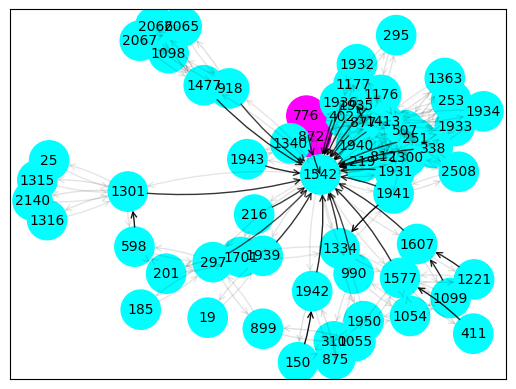

In [9]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

In [10]:
edge_mask_1 = edge_mask

In [11]:
node_idx = 1301
x, edge_index = data.x, data.edge_index
explainer = GNNExplainer(model, epochs=200)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

Explain node 1301: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 152.78it/s]


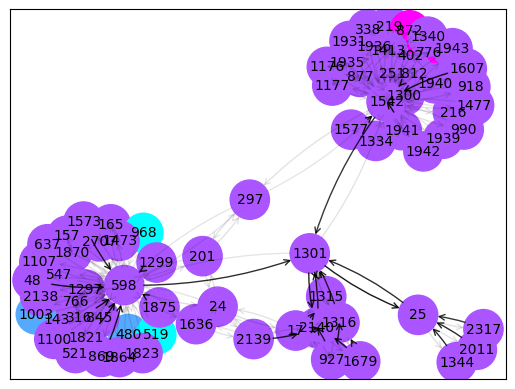

In [12]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

In [13]:
edge_mask_2 = edge_mask

In [14]:
edge_mask_1[edge_mask_1 > 0]

tensor([0.1031, 0.1003, 0.1038, 0.9239, 0.0847, 0.1086, 0.1085, 0.1156, 0.7697,
        0.1080, 0.1103, 0.0967, 0.8492, 0.1138, 0.1114, 0.0959, 0.1144, 0.1100,
        0.7341, 0.1218, 0.0847, 0.1164, 0.0931, 0.0887, 0.0739, 0.0963, 0.0911,
        0.1175, 0.1096, 0.6927, 0.1174, 0.0930, 0.0837, 0.1140, 0.1131, 0.8445,
        0.1098, 0.0915, 0.1040, 0.1222, 0.7767, 0.1067, 0.1164, 0.1103, 0.8918,
        0.1187, 0.0979, 0.1345, 0.1032, 0.1049, 0.1112, 0.1173, 0.1264, 0.1137,
        0.1348, 0.0956, 0.0987, 0.1264, 0.1057, 0.1096, 0.1215, 0.0955, 0.9030,
        0.1078, 0.1160, 0.8227, 0.0898, 0.1219, 0.0820, 0.1147, 0.7989, 0.1078,
        0.1015, 0.7997, 0.1208, 0.1299, 0.1027, 0.0817, 0.1021, 0.0960, 0.1070,
        0.7476, 0.9294, 0.0856, 0.1163, 0.1055, 0.7469, 0.1255, 0.1131, 0.1153,
        0.7200, 0.1026, 0.1049, 0.1186, 0.0998, 0.1259, 0.0975, 0.0653, 0.1387,
        0.1065, 0.1133, 0.1244, 0.0821, 0.8482, 0.1109, 0.1210, 0.1059, 0.7520,
        0.0938, 0.1119, 0.0989, 0.7837, 

In [15]:
torch.sigmoid(torch.logit(edge_mask_1[edge_mask_1 > 0]))

tensor([0.1031, 0.1003, 0.1038, 0.9239, 0.0847, 0.1086, 0.1085, 0.1156, 0.7697,
        0.1080, 0.1103, 0.0967, 0.8492, 0.1138, 0.1114, 0.0959, 0.1144, 0.1100,
        0.7341, 0.1218, 0.0847, 0.1164, 0.0931, 0.0887, 0.0739, 0.0963, 0.0911,
        0.1175, 0.1096, 0.6927, 0.1174, 0.0930, 0.0837, 0.1140, 0.1131, 0.8445,
        0.1098, 0.0915, 0.1040, 0.1222, 0.7767, 0.1067, 0.1164, 0.1103, 0.8918,
        0.1187, 0.0979, 0.1345, 0.1032, 0.1049, 0.1112, 0.1173, 0.1264, 0.1137,
        0.1348, 0.0956, 0.0987, 0.1264, 0.1057, 0.1096, 0.1215, 0.0955, 0.9030,
        0.1078, 0.1160, 0.8227, 0.0898, 0.1219, 0.0820, 0.1147, 0.7989, 0.1078,
        0.1015, 0.7997, 0.1208, 0.1299, 0.1027, 0.0817, 0.1021, 0.0960, 0.1070,
        0.7476, 0.9294, 0.0856, 0.1163, 0.1055, 0.7469, 0.1255, 0.1131, 0.1153,
        0.7200, 0.1026, 0.1049, 0.1186, 0.0998, 0.1259, 0.0975, 0.0653, 0.1387,
        0.1065, 0.1133, 0.1244, 0.0821, 0.8482, 0.1109, 0.1210, 0.1059, 0.7520,
        0.0938, 0.1119, 0.0989, 0.7837, 

In [16]:
new_edge_mask = torch.sigmoid(torch.logit(edge_mask_1) + torch.logit(edge_mask_2))

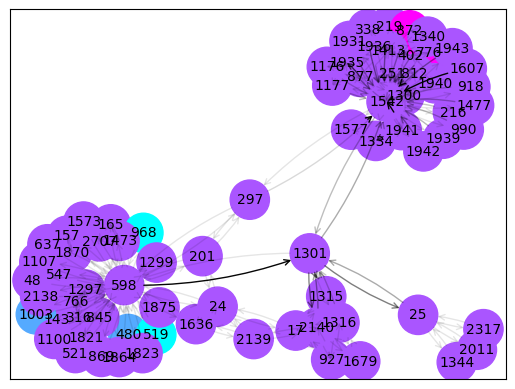

In [17]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, new_edge_mask, y=data.y)
plt.show()

## Modified GNNExplainer

In [18]:
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.nn.models.explainer import clear_masks, set_masks

EPS = 1e-15


class EdgeGNNExplainer(GNNExplainer):
    def _loss(self, log_logits, prediction, node_idx = None):
        if self.return_type == 'regression':
            if node_idx is not None and (node_idx >= 0).max():
                loss = torch.cdist(log_logits[node_idx], prediction[node_idx])
            else:
                loss = torch.cdist(log_logits, prediction)
        else:
            if node_idx is not None and (node_idx >= 0).max():
                loss = -log_logits[node_idx, prediction[node_idx]]
            else:
                loss = -log_logits[0, prediction[0]]

        if self.allow_edge_mask:
            m = self.edge_mask.sigmoid()
            edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
            loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
            ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
            loss = loss + self.coeffs['edge_ent'] * ent.mean()

        m = self.node_feat_mask.sigmoid()
        node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
        loss = loss + self.coeffs['node_feat_size'] * node_feat_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

        return loss
    
    def edge_subgraph(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)
        subset, edge_index, mapping, edge_mask = k_hop_subgraph(
            node_idx_1, self.num_hops + 1, edge_index, relabel_nodes=True,
            num_nodes=num_nodes, flow=self._flow())
        
        mapping_2 = (subset == node_idx_2).nonzero()[0].item()
        mapping = torch.tensor([mapping[0], mapping_2])
        
        x = x[subset]
        kwargs_new = {}
        for key, value in kwargs.items():
            if torch.is_tensor(value) and value.size(0) == num_nodes:
                kwargs_new[key] = value[subset]
            elif torch.is_tensor(value) and value.size(0) == num_edges:
                kwargs_new[key] = value[edge_mask]
            else:
                kwargs_new[key] = value  # TODO: this is not in PGExplainer
        return x, edge_index, mapping, edge_mask, subset, kwargs_new
    
    
    def explain_edge(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        self.model.eval()
        self._clear_masks()

        num_nodes = x.size(0)
        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, subset, kwargs = \
            self.edge_subgraph(node_idx_1, node_idx_2, x, edge_index, **kwargs)

        # Get the initial prediction.
        prediction = self.get_initial_prediction(x, edge_index, **kwargs)

        self._initialize_masks(x, edge_index)
        self.to(x.device)

        if self.allow_edge_mask:
            set_masks(self.model, self.edge_mask, edge_index, apply_sigmoid=True)
            parameters = [self.node_feat_mask, self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        # if self.log:  # pragma: no cover
        #     pbar = tqdm(total=self.epochs)
        #     pbar.set_description(f'Explain edge {node_idx_1, node_idx_2}')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.sigmoid()
            out = self.model(x=h, edge_index=edge_index, **kwargs)
            loss = self.get_loss(out, prediction, mapping).sum()
            loss.backward()
            optimizer.step()

            # if self.log:  # pragma: no cover
            #     pbar.update(1)

        # if self.log:  # pragma: no cover
        #     pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        if self.feat_mask_type == 'individual_feature':
            new_mask = x.new_zeros(num_nodes, x.size(-1))
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        elif self.feat_mask_type == 'scalar':
            new_mask = x.new_zeros(num_nodes, 1)
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        node_feat_mask = node_feat_mask.squeeze()

        if self.allow_edge_mask:
            edge_mask = self.edge_mask.new_zeros(num_edges)
            edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()
        else:
            edge_mask = torch.zeros(num_edges)
            edge_mask[hard_edge_mask] = 1

        self._clear_masks()

        return node_feat_mask, edge_mask

In [19]:
node_idx_1, node_idx_2 = 1542, 1301
x, edge_index = data.x, data.edge_index
edge_explainer = EdgeGNNExplainer(model, epochs=200)
node_feat_mask, edge_mask = edge_explainer.explain_edge(node_idx_1, node_idx_2, x, edge_index)

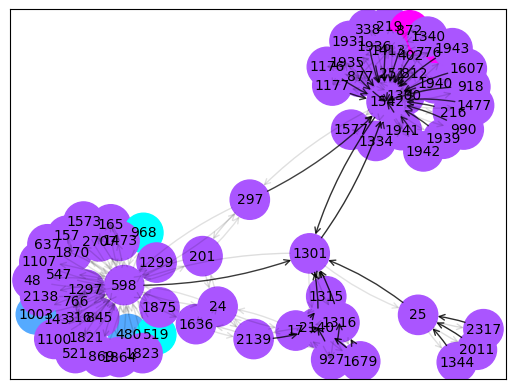

In [20]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()